In [ ]:
using Pkg             # Load the package manager

# ONLY RUN THIS IF YOU HAVE DIFFERENT VERSIONS OF THE PACKAGES BELOW INSTALLED
# This creates a new environment in the current working directory
#
# Pkg.activate(".")

# Install the packages we need
Pkg.add([ "Catalyst", "DifferentialEquations", "Plots", "Random", "Distributions" ])

   Resolving package versions...
  No Changes to `~/Documents/Code/clone-wars/Project.toml`
  No Changes to `~/Documents/Code/clone-wars/Manifest.toml`
Precompiling project...
    411.7 ms  ✓ mtdev_jll
    340.8 ms  ✓ libevdev_jll
    340.3 ms  ✓ Xorg_xcb_util_jll
    343.9 ms  ✓ gperf_jll
    297.8 ms  ✓ libdecor_jll
    264.3 ms  ✓ eudev_jll
    252.2 ms  ✓ Qt6Wayland_jll
  7 dependencies successfully precompiled in 2 seconds. 499 already precompiled.


In [2]:
using Catalyst

In [ ]:
# Initial set up using Catalyst.jl
# Two state model for demonstrative purposes
rn = @reaction_network begin
    μ_S, S --> 0        # stem cell death 
    μ_D, D --> 0        # differentiated cell death 
    σ, S --> 2*S        # stem cell division
    λ, S --> D          # differentiation 
    2*σ/K, 2*S --> S    # incorporating carrying capacity
end

Model ##ReactionSystem#247:
Unknowns (2): see unknowns(##ReactionSystem#247)
  S(t)
  D(t)
Parameters (5): see parameters(##ReactionSystem#247)
  μ_S
  μ_D
  σ
  λ
  ⋮

In [4]:
osys = convert(ODESystem, rn)

Model ##ReactionSystem#235:
Equations (2):
  2 standard: see equations(##ReactionSystem#235)
Unknowns (2): see unknowns(##ReactionSystem#235)
  S(t)
  D(t)
Parameters (5): see parameters(##ReactionSystem#235)
  μ_S
  μ_D
  σ
  λ
  ⋮

In [ ]:
# Model parameters and values
p = [ :μ_S => 0.1, 
      :μ_D => 0.2,
      :σ => 0.3,
      :λ => 0.15,
      :K => 100 ]

# Initial conditions
u0 = [ :S => 1, :D => 0 ]

# Simulation length
tmax = 100.0;

In [ ]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(rn, u0, (0, tmax), p)
sol = solve(prob);

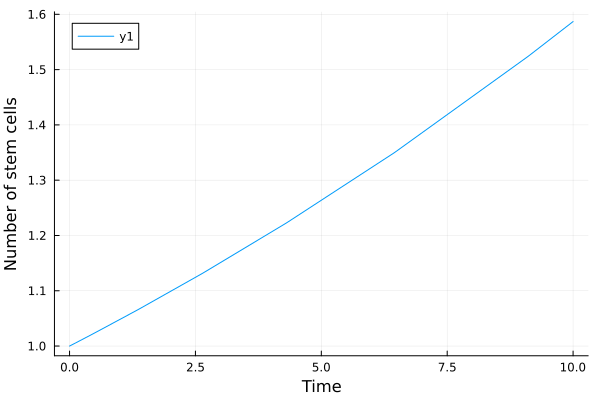

In [21]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of stem cells")

In [ ]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(rn, u0, (0, tmax), p)
prob = JumpProblem(jinp);
sol = solve(prob);

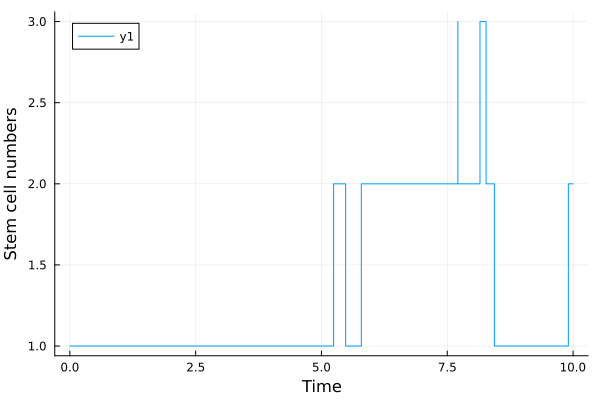

In [24]:
plt = plot(sol.t, sol[:S], 
           xlabel="Time", 
           ylabel="Stem cell numbers", 
           linetype=:steppost)

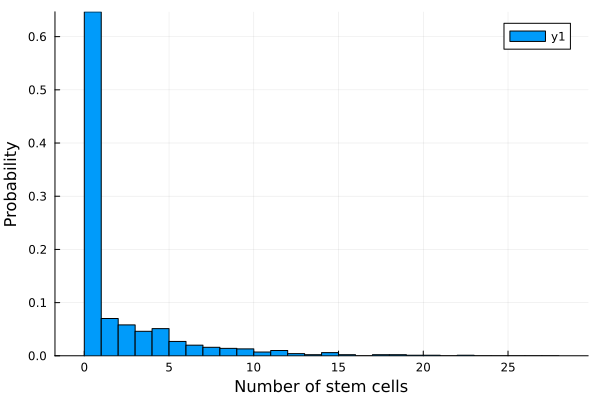

In [26]:
# Array to store the result of each simulation
ns = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of stem cells", 
          ylabel="Probability") 

# Coarse differentiation
Two levels of pluripotency. At the highest level, have one cell type: hematopoietic stem cell. At the lowest level, have three cell types: lymphoid, erythroid and myeloid cells. If transdifferentiation is permitted, all cell types in the low level of pluripotency can turn into each other. If dedifferentiation is permitted, cell types from the lower pluripotency level can become stem cells. We assume that differentiation is always permitted, and therefore a stem cell may always differentiate into a less pluripotent cell type. Assume all cells can undergo cell death. When cells divide, they produce two cells of the same type as the parent cell. In this 'simplified' set up, there are 20 possible reactions and 20 parameters (without incorporating carrying capacity - with carrying capacity, there are a further four reactions and parameters, assuming carrying capacities are independent... Which is probably a bad assumption).

In [6]:
# Set up the network
# To do: automate this
differentiation_network = @reaction_network begin
    # Cell death
    μ_S, S --> 0        # stem cell death 
    μ_L, L --> 0        # lymphoid cell death
    μ_E, E --> 0        # erythroid cell death 
    μ_M, M --> 0        # myeloid cell death
    # Cell division
    σ_S, S --> 2*S      # stem cell division
    2*σ_S/K_S, 2*S --> S  # incorporating carrying capacity for stem cells
    σ_L, L --> 2*L      # lymphoid cell division
    2*σ_L/K_L, 2*L --> L  # incorporating carrying capacity for lymphoid cells
    σ_E, E --> 2*E      # erythroid cell division
    2*σ_E/K_E, 2*E --> E  # incorporating carrying capacity for erythroid cells
    σ_M, M --> 2*M      # myeloid cell division
    2*σ_M/K_M, 2*M --> M    # incorporating carrying capacity for myeloid cells
    # Differentiation and dedifferentiation
    λ_SL, S --> L       # differentiation from a stem cell into a lymphoid cell
    α_LS, L --> S       # dedifferentiation from a lymphoid cell into a stem cell
    λ_SE, S --> E       # differentiation from a stem cell into an erythroid cell
    α_ES, E --> S       # dedifferentiation from an erythroid cell into a stem cell
    λ_SM, S --> M       # differentiation from a stem cell into a myeloid cell
    α_MS, M --> S       # dedifferentiation from a myeloid cell into a stem cell
    
    # Transdifferentiation
    β_LE, L --> E       # transdifferentiation from a lymphoid cell into an erythroid cell
    β_EL, E --> L       # transdifferentiation from an erythroid cell into a lymphoid cell 
    β_LM, L --> M       # transdifferentiation from a lymphoid cell into a myeloid cell
    β_ML, M --> L       # transdifferentiation from a myeloid cell into a lymphoid cell 
    β_EM, E --> M       # transdifferentiation from an erythroid cell into a myeloid cell
    β_ME, M --> E       # transdifferentiation from a myeloid cell into an erythroid cell 
end

Model ##ReactionSystem#257:
Unknowns (4): see unknowns(##ReactionSystem#257)
  S(t)
  L(t)
  E(t)
  M(t)
Parameters (24): see parameters(##ReactionSystem#257)
  μ_S
  μ_L
  μ_E
  μ_M
  ⋮

In [7]:
osys = convert(ODESystem, differentiation_network)

Model ##ReactionSystem#257:
Equations (4):
  4 standard: see equations(##ReactionSystem#257)
Unknowns (4): see unknowns(##ReactionSystem#257)
  S(t)
  L(t)
  E(t)
  M(t)
Parameters (24): see parameters(##ReactionSystem#257)
  μ_S
  μ_L
  μ_E
  μ_M
  ⋮

In [19]:
# Model parameters and values
p = [ :μ_S => 0.05, 
      :μ_L => 0.2,
      :μ_E => 0.2,
      :μ_M => 0.2,
      :σ_S => 0.4,
      :σ_L => 0.1,
      :σ_E => 0.1,
      :σ_M => 0.1,
      :λ_SL => 0.1,
      :λ_SE => 0.1,
      :λ_SM => 0.1,
      :α_LS => 0.01,
      :α_ES => 0.01,
      :α_MS => 0.01,
      :β_LE => 0.05,
      :β_EL => 0.05,
      :β_LM => 0.05,
      :β_ML => 0.05,
      :β_EM => 0.05,
      :β_ME => 0.05,
      :K_S => 1000,
      :K_L => 500,
      :K_E => 500,
      :K_M => 500 ]

# Initial conditions
u0 = [ :S => 1, :L => 0, :E => 0, :M => 0 ]

# Simulation length
tmax = 100.0;

In [20]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(differentiation_network, u0, (0, tmax), p)
sol = solve(prob);

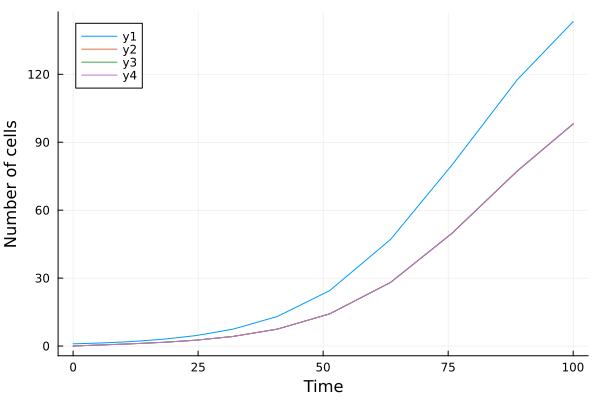

In [21]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of cells")

plot!(sol.t, sol[:L])    
plot!(sol.t, sol[:E])
plot!(sol.t, sol[:M])  

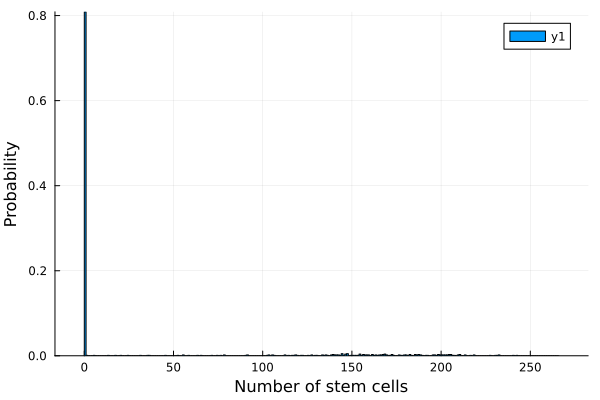

In [22]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(differentiation_network, u0, (0, tmax), p)
prob = JumpProblem(jinp);
# Array to store the result of each simulation
ns = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of stem cells", 
          ylabel="Probability") 